<a href="https://colab.research.google.com/github/yerartdev/tfm-pb/blob/master/poc_colab_r_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gerardo de Miguel González

## irkernel

Ejemplo de Ejecución de R en Python:

https://colab.research.google.com/github/IRkernel/IRkernel/blob/master/example-notebooks/Demo.ipynb#scrollTo=UVye7K3FEnEM

que también [se puede encontrar en Github](https://github.com/IRkernel/IRkernel/tree/master/example-notebooks) y [se puede abrir desde Github](https://colab.research.google.com/github/IRkernel/).

Obtenido de una entrada en StackExchange:

- [How to use R with Google Colaboratory? - Stack Overflow](https://stackoverflow.com/questions/54595285/how-to-use-r-with-google-colaboratory)

Aperentemente de momento [no hay soporte oficial](https://research.google.com/colaboratory/faq.html) de R (o Julia) aunque [hay gente que se lo ha currado](https://discourse.mc-stan.org/t/r-jupyter-notebook-rstan-on-google-colab/6101) con [más o menos hacking](https://gist.github.com/simecek/019d87c55fec3839d95bbf8489dde61d).

NOTA: no he encontrado manera de ejecutar R creando un nuevo notebook desde cero en Google Drive porque solamente te ofrece el enorno de ejecución Python.

## References

**::GMG::** I've followed these references:

  - [Machine Learning Process](https://machinelearningmastery.com/an-introduction-to-feature-selection/) An Introduction to Feature Selection. By Jason Brownlee on October 6, 2014.
  - [R Machine Learning](https://machinelearningmastery.com/feature-selection-with-the-caret-r-package/) Feature Selection with the Caret R Package. By Jason Brownlee on September 22, 2014

## Libraries

In [0]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    if(length(need)>0){ 
        install.packages(need)
        lapply(need,require,character.only=TRUE)
    }
}

In [0]:
using('repr','mlbench', 'e1071', 'randomForest','caret')

## Dataset

In [0]:
#::GMG::There are two versions in mlbench
# https://www.rdocumentation.org/packages/utils/versions/3.6.1/topics/data
#::NOTE::2nd version comes with zero outliers as NAs
utils::data(PimaIndiansDiabetes2)

In [4]:
#::GMG::See first rows
# https://www.rdocumentation.org/packages/utils/versions/3.6.1/topics/head
#::NOTE::Some NAs show up!
utils::head(PimaIndiansDiabetes2)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,pos
1,85,66,29,NA,26.6,0.351,31,neg
8,183,64,NA,NA,23.3,0.672,32,pos
1,89,66,23,94,28.1,0.167,21,neg
0,137,40,35,168,43.1,2.288,33,pos
5,116,74,NA,NA,25.6,0.201,30,neg


## Exploratory Data Analysis

In [5]:
#::GMG::PimaIndiansDiabetes2 (say, v2) has the outliers from 
#       glucose, pressure, triceps, insulin and mass as NAs
str(PimaIndiansDiabetes2)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 NA 70 96 ...
 $ triceps : num  35 29 NA 23 35 NA 32 NA 45 NA ...
 $ insulin : num  NA NA NA 94 168 NA 88 NA 543 NA ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 NA ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


In [6]:
#::GMG::NA counts yield the outliers (!)
#::NOTE::Should I standardize some of the features ('glucose', 'pressure', 'triceps', 'insuline', 'mass')?
#::NOTE::Should I do feature engineering on some of the features 
#        (i.e. age, p.e breaking it into intervals with labels)?
summary(PimaIndiansDiabetes2)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   : 44.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 64.00   1st Qu.:22.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :29.00  
 Mean   : 3.845   Mean   :121.7   Mean   : 72.41   Mean   :29.15  
 3rd Qu.: 6.000   3rd Qu.:141.0   3rd Qu.: 80.00   3rd Qu.:36.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
                  NA's   :5       NA's   :35       NA's   :227    
    insulin            mass          pedigree           age        diabetes 
 Min.   : 14.00   Min.   :18.20   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.: 76.25   1st Qu.:27.50   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median :125.00   Median :32.30   Median :0.3725   Median :29.00            
 Mean   :155.55   Mean   :32.46   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:190.00   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 M

In [11]:
#::GMG::Check for missing values ... I know they are marked witn 'NA' in mlbench 2nd dataset
print(sapply(PimaIndiansDiabetes2, function(x) sum(is.na(x))))

pregnant  glucose pressure  triceps  insulin     mass pedigree      age 
       0        5       35      227      374       11        0        0 
diabetes 
       0 


In [8]:
#::GMG::Now I test the imbalance of the dataset
# http://metadatascience.com/2013/07/03/plotting-the-frequency-distribution-using-r/
table(PimaIndiansDiabetes2$diabetes)


neg pos 
500 268 

In [9]:
prop.table(table(PimaIndiansDiabetes2$diabetes))


      neg       pos 
0.6510417 0.3489583 

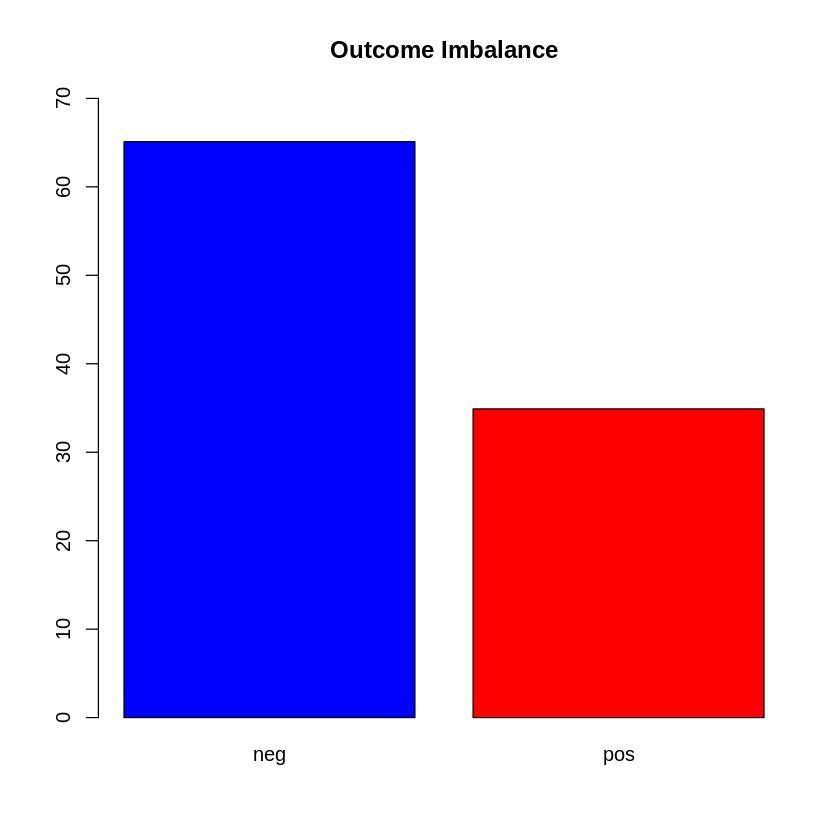

In [10]:
#::GMG::Plot the imbalance
# https://www.statmethods.net/advgraphs/parameters.html
# https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
#options(repr.plot.width=6, repr.plot.height=8)
barplot(100*prop.table(table(PimaIndiansDiabetes2$diabetes)), 
        col = c('blue', 'red'),
        ylim = c(0,70),
        main = 'Outcome Imbalance')

## Preparing the data

In [0]:
#::GMG::I reach a final decision here: emove NAs
#::NOTE::My goal here is feature selection showcase; of course, en tfm o real situation
#        I'll have to do imputation or selective removal
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/na.fail.html
# https://www.statmethods.net/input/missingdata.html
pima_clean <- stats::na.omit(PimaIndiansDiabetes2)

In [36]:
#::GMG::Check for missing values ... No NAs after cleaning with na.omit()
# https://stackoverflow.com/questions/41621467/print-a-named-vector-in-r
outliers <- sapply(pima_clean, function(x) sum(is.na(x)))
cat(paste(names(outliers), outliers, sep = ":", collapse = "\n"))

pregnant:0
glucose:0
pressure:0
triceps:0
insulin:0
mass:0
pedigree:0
age:0
diabetes:0

In [14]:
#::NOTE::Originally 768 Observations!!
str(pima_clean)

'data.frame':	392 obs. of  9 variables:
 $ pregnant: num  1 0 3 2 1 5 0 1 1 3 ...
 $ glucose : num  89 137 78 197 189 166 118 103 115 126 ...
 $ pressure: num  66 40 50 70 60 72 84 30 70 88 ...
 $ triceps : num  23 35 32 45 23 19 47 38 30 41 ...
 $ insulin : num  94 168 88 543 846 175 230 83 96 235 ...
 $ mass    : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ pedigree: num  0.167 2.288 0.248 0.158 0.398 ...
 $ age     : num  21 33 26 53 59 51 31 33 32 27 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 1 2 2 2 2 2 2 1 2 1 ...
 - attr(*, "na.action")= 'omit' Named int  1 2 3 6 8 10 11 12 13 16 ...
  ..- attr(*, "names")= chr  "1" "2" "3" "6" ...


In [15]:
# Inspect the data
# https://www.rdocumentation.org/packages/utils/versions/3.6.1/topics/head
utils::head(pima_clean)

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4,1,89,66,23,94,28.1,0.167,21,neg
5,0,137,40,35,168,43.1,2.288,33,pos
7,3,78,50,32,88,31.0,0.248,26,pos
9,2,197,70,45,543,30.5,0.158,53,pos
14,1,189,60,23,846,30.1,0.398,59,pos
15,5,166,72,19,175,25.8,0.587,51,pos


## Remove redundant features

In [0]:
#::GMG::Make it reproducble
set.seed(1)

In [0]:
#::GMG::calculate correlation matrix
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/cor
# https://www.rdocumentation.org/packages/base/versions/3.6.1/topics/names
# https://stackoverflow.com/questions/5234117/how-to-drop-columns-by-name-in-a-data-frame
correlationMatrix <- stats::cor(
    pima_clean[,!base::names(pima_clean) %in% c('diabetes')]
)

In [18]:
#::GMG::summarize the correlation matrix
print(correlationMatrix)

             pregnant   glucose   pressure   triceps    insulin        mass
pregnant  1.000000000 0.1982910  0.2133548 0.0932094 0.07898363 -0.02534728
glucose   0.198291043 1.0000000  0.2100266 0.1988558 0.58122301  0.20951592
pressure  0.213354775 0.2100266  1.0000000 0.2325712 0.09851150  0.30440337
triceps   0.093209397 0.1988558  0.2325712 1.0000000 0.18219906  0.66435487
insulin   0.078983625 0.5812230  0.0985115 0.1821991 1.00000000  0.22639652
mass     -0.025347276 0.2095159  0.3044034 0.6643549 0.22639652  1.00000000
pedigree  0.007562116 0.1401802 -0.0159711 0.1604985 0.13590578  0.15877104
age       0.679608470 0.3436415  0.3000389 0.1677611 0.21708199  0.06981380
             pedigree        age
pregnant  0.007562116 0.67960847
glucose   0.140180180 0.34364150
pressure -0.015971104 0.30003895
triceps   0.160498526 0.16776114
insulin   0.135905781 0.21708199
mass      0.158771043 0.06981380
pedigree  1.000000000 0.08502911
age       0.085029106 1.00000000


In [24]:
#::GMG::Using caret::findCorrelation() function to find that are highly correlated with each other
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/findCorrelation
# The absolute values of pair-wise correlations are considered. If two variables have a high correlation, 
# the function looks at the mean absolute correlation of each variable and removes the variable with the 
# largest mean absolute correlation.
#::NOTE::Generally, you want to remove attributes with an absolute correlation of 0.75 or higher
highlyCorrelated <- caret::findCorrelation(correlationMatrix, cutoff=0.5, names = FALSE)
cat(sep = '\n', 'Features to remove:', names(pima_clean)[highlyCorrelated])

Features to remove:
glucose
age
triceps


In [33]:
#::GMG::So if I want to apply this criteria
# https://stackoverflow.com/questions/42932663/findcorrelation-function-in-r
selected_features <- names(pima_clean)[-highlyCorrelated]
cat(sep = '\n', 'Selected features (and target):', selected_features)

Selected features (and target):
pregnant
pressure
insulin
mass
pedigree
diabetes


## Rank Features By Importance

### using LVQ

In [0]:
#::GMG::Make it reproducble
set.seed(2)

In [0]:
#::GMG::The importance of features can be estimated from data by building a model
#::NOTE::Here I use a Learning Vector Quantization (LVQ) model
# https://machinelearningmastery.com/learning-vector-quantization-for-machine-learning/
#::GMG::prepare training scheme
# https://cran.r-project.org/web/packages/caret/vignettes/caret.html
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/trainControl
control <- caret::trainControl(
      method="repeatedcv", 
      number = 10, 
      repeats = 3)

In [0]:
#::GMG::train the model
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/train
model <- caret::train(
    diabetes~., 
    data = pima_clean, 
    method = "lvq", 
    preProcess = "scale", 
    trControl = control
)

In [42]:
#::GMG::estimate variable importance
importance <- caret::varImp(model, scale=FALSE)
print(importance)

ROC curve variable importance

         Importance
glucose      0.8058
age          0.7432
insulin      0.7299
mass         0.6638
triceps      0.6594
pedigree     0.6215
pregnant     0.6214
pressure     0.6213


In [43]:
str(importance)

List of 3
 $ importance:'data.frame':	8 obs. of  2 variables:
  ..$ neg: num [1:8] 0.621 0.806 0.621 0.659 0.73 ...
  ..$ pos: num [1:8] 0.621 0.806 0.621 0.659 0.73 ...
 $ model     : chr "ROC curve"
 $ calledFrom: chr "varImp"
 - attr(*, "class")= chr "varImp.train"


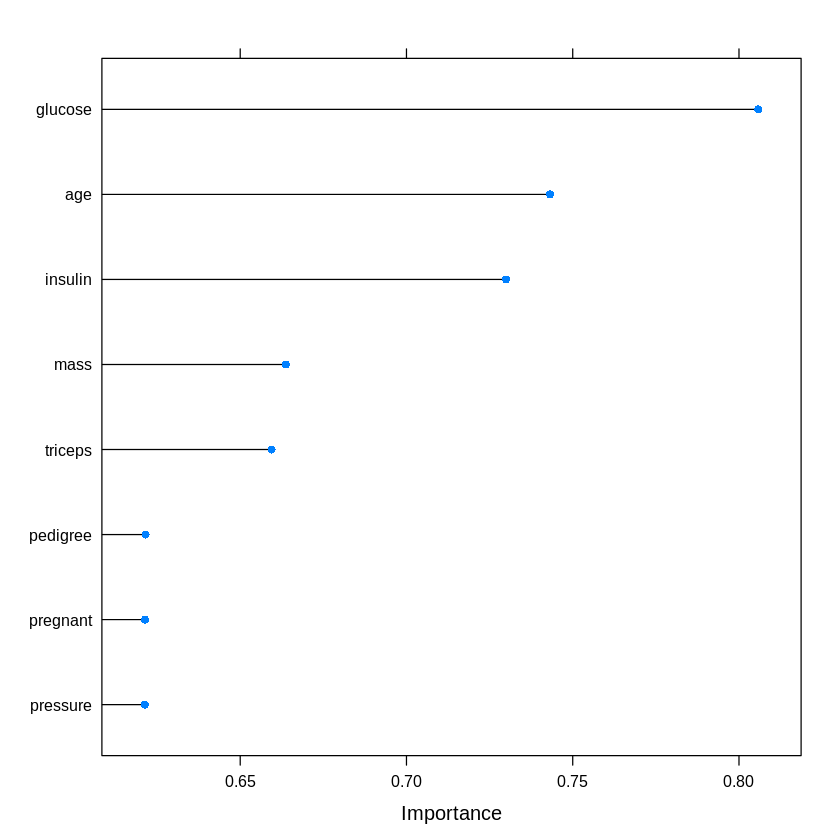

In [44]:
#::GMG::plot importance
plot(importance)

## RFE (wrapper approach)

### using RandomForest

**::NOTE::** Here I think I can use the best model with the selected feature as a baseline model for the data!

In [0]:
#::GMG::Make it reproducble
set.seed(3)

In [0]:
#::GMG::Now the approach is to build many models with different subsets of a dataset and identify those attributes
#       that are and are not required to build an accurate model
#::NOTE::I'm going to use RandomForest as the model here, I could have used a plain Logistic Regression model too
#::GMG::define the control using a random forest selection function
#::NOTE::Then again caret takes care of split 10-fold CV 
#        Perhaps I should use repeated 10-fold CV here too
# https://topepo.github.io/caret/recursive-feature-elimination.html
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/rfeControl
control_rfe <- caret::rfeControl(
    functions = rfFuncs, 
    method = "cv", 
    number = 10)

In [0]:
#::GMG::run the RFE algorithm
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/rfe
#::NOTE::I use CV here, which is best practice, and use the whole dataset, which
#        means I will need a test dataset somewhere to test the resulting model
#::NOTE::Here instead of the formula I split the features/target; it's reported
#        in documentation that the formula approach may put a burden in the
#        algorithm when the dataset is big
#::NOTE::metric "Accuracy" is implied here (this is not correct with this dataset)
results <- caret::rfe(
    x = pima_clean[,!base::names(pima_clean) %in% c('diabetes')], 
    y = pima_clean[, 'diabetes'], 
    sizes = c(1: length(names(pima_clean)) - 1), 
    rfeControl = control_rfe)

In [51]:
#::GMG::summarize the results
#::NOTE::I can choose the metrics in rfe(), see doc
# https://cran.r-project.org/web/packages/caret/vignettes/caret.html
# https://topepo.github.io/caret/recursive-feature-elimination.html
#::NOTE::I would pick prSummary and metric AUC (PR AUC) to optimize here
#        because of the unbalanced dataset!
# https://topepo.github.io/caret/measuring-performance.html#measures-for-class-probabilities
print(results)


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         0   0.7372 0.4002    0.07241  0.1515         
         1   0.7372 0.4002    0.07241  0.1515         
         2   0.7449 0.4060    0.08022  0.1938         
         3   0.7732 0.4863    0.08907  0.1981         
         4   0.7833 0.5081    0.08577  0.1906        *
         5   0.7783 0.4978    0.09367  0.2074         
         6   0.7683 0.4740    0.08824  0.1956         
         7   0.7656 0.4630    0.06853  0.1468         
         8   0.7785 0.4892    0.07557  0.1652         

The top 4 variables (out of 4):
   glucose, age, insulin, mass



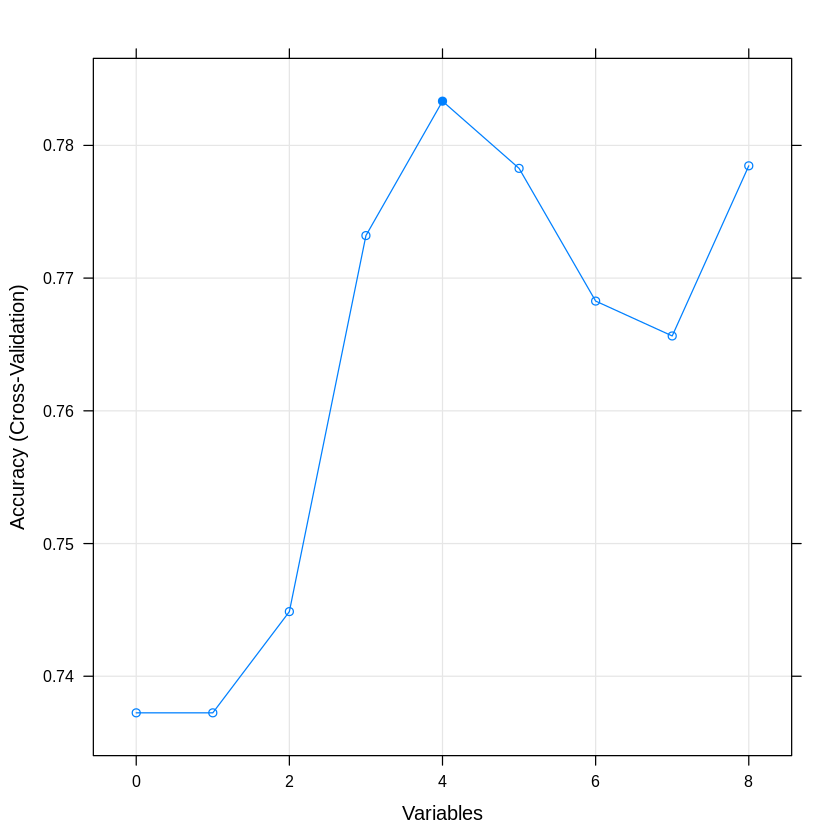

In [52]:
#::GMG::plot the results
plot(results, type=c("g", "o"))

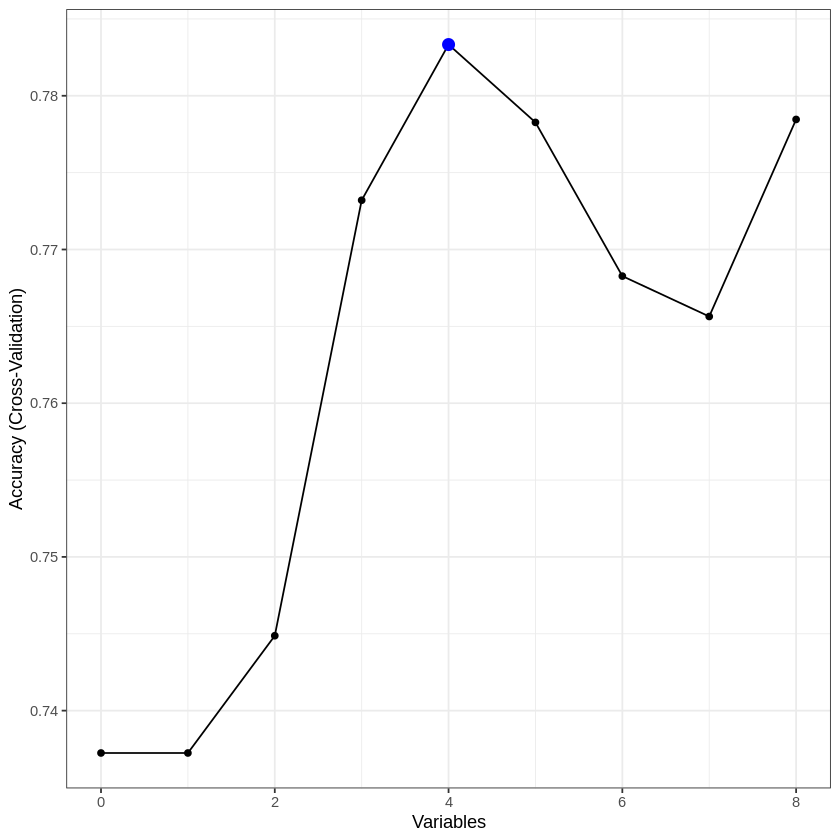

In [54]:
ggplot(results) + theme_bw()